In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from spacy.lang.en import English

In [2]:
complaints = pd.read_csv('complaints.csv')

In [3]:
complaints[['Consumer complaint narrative', 'Issue']] = complaints[['Consumer complaint narrative', 'Issue']].astype('str')

In [5]:
nlp = English()
counts_by_issue = {}

for issue in complaints['Issue'].unique():
    issue_df = complaints[complaints['Issue'] == issue]
    count = 0
    for complaint in issue_df['Consumer complaint narrative']:
        doc = nlp(complaint)
        for token in doc:
            if token.is_alpha and token.is_title:
                count += 1
    counts_by_issue[issue] = count

print(counts_by_issue)

{'Incorrect information on your report': 3770465, 'Fraud or scam': 295333, 'Attempts to collect debt not owed': 1289670, 'Communication tactics': 280825, 'Struggling to pay mortgage': 572361}


In [6]:
cols = ['Consumer complaint narrative', 'Issue']
complaints = complaints[cols]

In [7]:
complaints['category_id'] = complaints['Issue'].factorize()[0]
category_id_complaints = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_complaints.values)
id_to_category = dict(category_id_complaints[['category_id', 'Issue']].values)
complaints.head()

,Consumer complaint narrative,Issue,category_id
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report,0
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam,1
2,I have a particular account that is stating th...,Incorrect information on your report,0
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,2
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,0


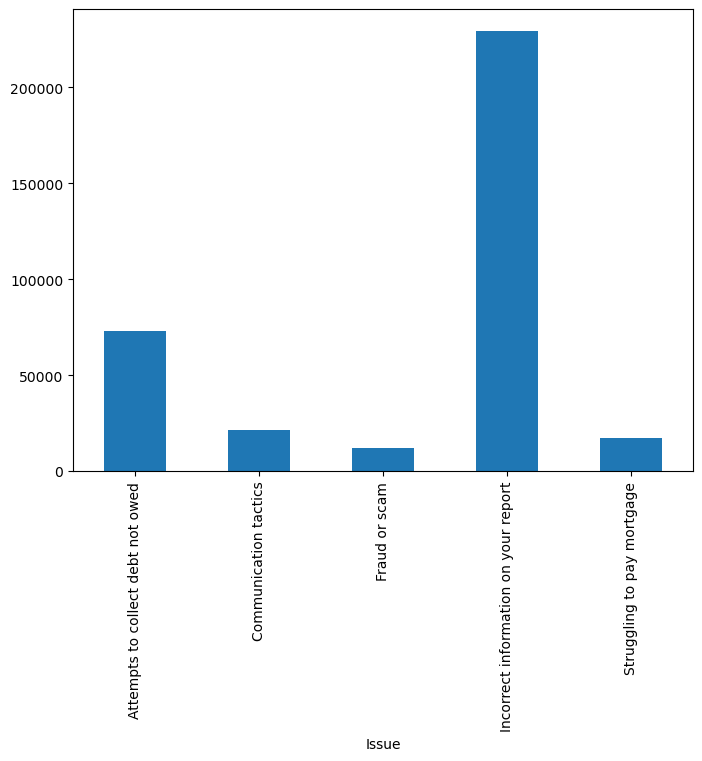

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
complaints.groupby('Issue')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=750, ngram_range=(2,2), stop_words='english')
features = tfidf.fit_transform(complaints['Consumer complaint narrative']).toarray()
labels = complaints.category_id
features.shape

(353432, 3749)

In [15]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Issue, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Issue))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Attempts to collect debt not owed':
  . Most correlated bigrams:
. collect debt
. collection agency
# 'Communication tactics':
  . Most correlated bigrams:
. stop calling
. times day
# 'Fraud or scam':
  . Most correlated bigrams:
. wire transfer
. sent money
# 'Incorrect information on your report':
  . Most correlated bigrams:
. loan modification
. collect debt
# 'Struggling to pay mortgage':
  . Most correlated bigrams:
. short sale
. loan modification


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(complaints['Consumer complaint narrative'], complaints['Issue'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

C:\Users\Pupnsuds90\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pupnsuds90\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

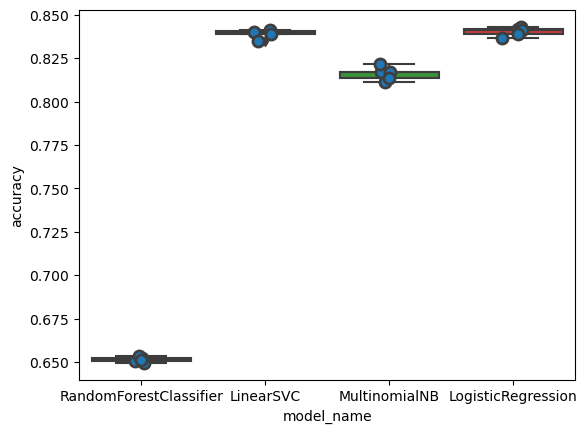

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.839310
LogisticRegression        0.840312
MultinomialNB             0.816222
RandomForestClassifier    0.651469
Name: accuracy, dtype: float64

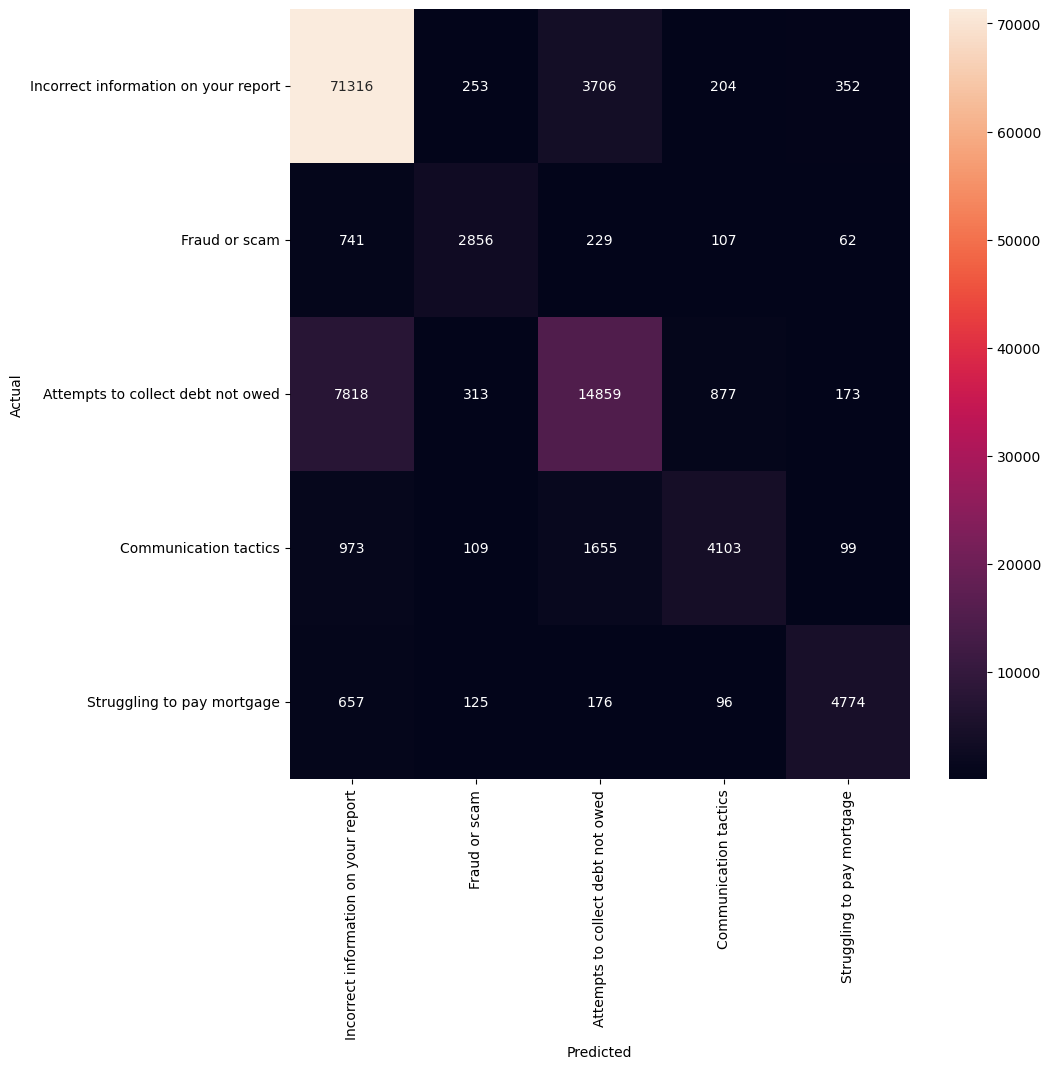

In [19]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, complaints.index, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_complaints.Issue.values, yticklabels=category_id_complaints.Issue.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=complaints['Issue'].unique()))

                                      precision    recall  f1-score   support

Incorrect information on your report       0.87      0.94      0.91     75831
                       Fraud or scam       0.78      0.71      0.75      3995
   Attempts to collect debt not owed       0.72      0.62      0.67     24040
               Communication tactics       0.76      0.59      0.67      6939
          Struggling to pay mortgage       0.87      0.82      0.85      5828

                            accuracy                           0.84    116633
                           macro avg       0.80      0.74      0.77    116633
                        weighted avg       0.83      0.84      0.83    116633

